###### **Data Preparation**

In [ ]:
# Clears the directory containing the best model.
shutil.rmtree('./best_models')
os.mkdir("best_models")

In [ ]:
# Import required modules
from keras.preprocessing.image import ImageDataGenerator

# Set hyperparameters
epochs = 20   # number of epochs
img_height, img_width = 224, 224    # image dimensions
batch_size = 32   # batch size
class_mode = "sparse"   # class mode

# Create ImageDataGenerator objects for train and validation datasets
train_gen = ImageDataGenerator(rotation_range=30, fill_mode='nearest',
                               width_shift_range=0.2, height_shift_range=0.2,
                               zoom_range=0.3, horizontal_flip=True)
valid_gen = ImageDataGenerator()

# Define paths for train and validation datasets
train_path = "./train_photos"
val_path = "./val_photos"

# Create train and validation generators
train_generator = train_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode=class_mode
)

val_generator = valid_gen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)


Found 3511 images belonging to 3 classes.
Found 879 images belonging to 3 classes.


The dataset was divided into training and validation sets, with the training set containing 3511 images and the validation set containing 879 images. Both sets include examples from all three classes. The validation set constitutes 20% of the entire dataset, while the training set takes up the remaining 80%. This split allows the model to be trained on a large majority of the data, while still having a separate set of examples to evaluate its performance on.

###### **Model Building**

The InceptionResNetV2 model architecture was chosen for training the data. This architecture is a variant of the Inception model, which has shown good performance on image classification tasks. In this case, the model was frozen, meaning that its weights were not updated during training, except for the last four layers, which were made trainable. This allowed the model to learn new features specific to the dataset at hand, while still leveraging the pre-trained weights. During training, the data was processed in batches of size 32. The activation function used was softmax, which maps the output of the model to probabilities for each class. The loss metric used to guide the optimization process was sparse categorical crossentropy, which is suitable for multi-class classification problems. The Adam optimizer was used to adjust the model's weights based on the loss. To measure the model's performance, the metric of interest was sparse categorical accuracy, which indicates the fraction of correctly classified examples. To ensure that the model's performance improved during training, a checkpoint was created to identify the model with the lowest validation loss and store it in a directory for later use. This allowed the model to be restored from the best state it reached during training, instead of using the final state, which may not necessarily be the best one.

In [ ]:
from keras.layers import Input, Dense, Flatten, Rescaling, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy

#InceptionResNetV2 model
incep_model = InceptionResNetV2(include_top=False,
                                input_shape=train_generator.image_shape)
# Freeze model
incep_model.trainable = False

# Set last four layers of InceptionResNetV2 model as trainable
for layer in incep_model.layers[:-4]:
    layer.trainable = True

# Define input layer
inputs = Input(shape=(224,224,3))

# Define scaling layer
scale_layer = Rescaling(scale=1./255, offset=-1)(inputs)

# Apply InceptionResNetV2 model to scaling layer
x = incep_model(scale_layer, training=False)

# Define global average pooling layer
x = GlobalAveragePooling2D()(x)

# Define dropout layer
x = Dropout(0.2)(x)

# Define output layer
outputs = Dense(3, activation="softmax")(x)

# Define model
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=[SparseCategoricalAccuracy()])

# Define checkpoint filepath
checkpoint_filepath = './best_models/lowest_val_loss.h5'

# Define checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                verbose=1,
                                                monitor='val_loss',
                                                save_best_only=True)

# Print model summary
model.summary()

219055592/219055592 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                            

To avoid overfitting, an early stopping mechanism was used when fitting the model. This technique allows the training process to be interrupted if the model does not show any improvement on the validation set for a certain number of consecutive epochs.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=2, 
                               mode='auto')
# Fit model
model_history = model.fit(train_generator, 
                          epochs=epochs, 
                          callbacks=[early_stopping,checkpoint],
                          validation_data=val_generator)

Epoch 1/20
110/110 [==============================] - ETA: 0s - loss: 0.6164 - sparse_categorical_accuracy: 0.7801
Epoch 1: val_loss improved from inf to 0.39722, saving model to ./best_models/lowest_val_loss.h5
110/110 [==============================] - 169s 1s/step - loss: 0.6164 - sparse_categorical_accuracy: 0.7801 - val_loss: 0.3972 - val_sparse_categorical_accuracy: 0.8419
Epoch 2/20
110/110 [==============================] - ETA: 0s - loss: 0.4955 - sparse_categorical_accuracy: 0.8092
Epoch 2: val_loss improved from 0.39722 to 0.39059, saving model to ./best_models/lowest_val_loss.h5
110/110 [==============================] - 141s 1s/step - loss: 0.4955 - sparse_categorical_accuracy: 0.8092 - val_loss: 0.3906 - val_sparse_categorical_accuracy: 0.8510
Epoch 3/20
110/110 [==============================] - ETA: 0s - loss: 0.4422 - sparse_categorical_accuracy: 0.8317
Epoch 3: val_loss improved from 0.39059 to 0.33013, saving model to ./best_models/lowest_val_loss.h5
110/110 [=======

###### **Data Visualization**

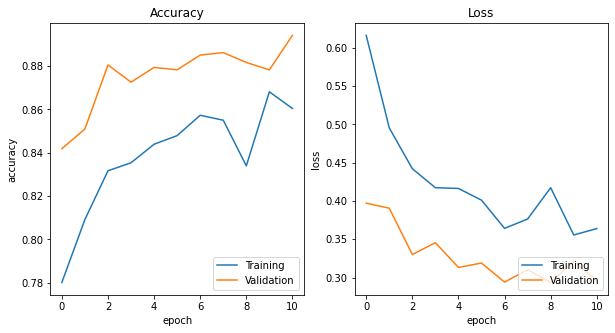

In [ ]:
# Import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot model accuracy on first subplot
ax1.plot(model_history.history['sparse_categorical_accuracy'])
ax1.plot(model_history.history['val_sparse_categorical_accuracy'])
ax1.set_title('Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['Training', 'Validation'], loc='lower right')

# Plot model loss on second subplot
ax2.plot(model_history.history['loss'])
ax2.plot(model_history.history['val_loss'])
ax2.set_title('Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['Training', 'Validation'], loc='lower right')

# Show plots
plt.show()

The training process was monitored using graphs that showed the model's accuracy and loss over time. As can be seen in the graph, both metrics increased in the first few epochs, indicating that the model was learning and making progress. However, at some point, there was a dip in both the accuracy and loss, where the model's performance temporarily decreased. Both metrics increased again after the dip, suggesting that the model recovered and continued to learn indicating that the chosen model architecture and training hyperparameters are suitable for the task at hand.

###### **Metrics**

In [ ]:
best_model = tf.keras.models.load_model("./best_models/lowest_val_loss.h5")
predictions = best_model.predict(val_generator)

28/28 [==============================] - 25s 807ms/step


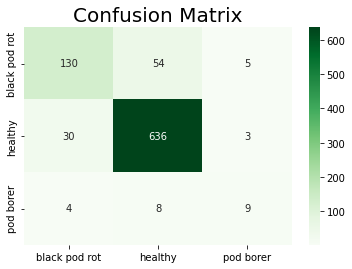

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for validation set
confusion = confusion_matrix(val_generator.classes,
                          np.argmax(predictions, axis=1))

# Define labels for confusion matrix
labels = ['black pod rot', 'healthy', 'pod borer']

# Plot confusion matrix for validation set
plt.title("Confusion Matrix", fontsize =20)
axis = sns.heatmap(confusion,
                     cmap="Greens",
                     annot=True,
                     xticklabels=labels,
                     yticklabels=labels,
                     fmt="d")

The model's performance on the validation set was analyzed using a heatmap that showed the distribution of correct and incorrect predictions for each class. As can be seen in the heatmap, the model made the least number of wrong predictions for the healthy class, indicating that it was able to correctly classify most examples from this class. On the other hand, the black pod rot and pod borer class showed a large number of wrong predictions, indicating that the model struggled to correctly classify examples from this class.

In [ ]:
pred_classes = np.argmax(predictions, axis=1)
classes = val_generator.classes
print(classification_report(classes, pred_classes, target_names=labels))

               precision    recall  f1-score   support

black pod rot       0.79      0.69      0.74       189
      healthy       0.91      0.95      0.93       669
    pod borer       0.53      0.43      0.47        21

     accuracy                           0.88       879
    macro avg       0.74      0.69      0.71       879
 weighted avg       0.88      0.88      0.88       879



As can be seen in the results, the healthy class had the highest precision, followed by the black pod rot and pod borer classes. This indicates that the model was able to correctly predict 91% of the healthy examples, 79% of the black pod rot examples, and 53% of the pod borer examples. In other words, the model was relatively confident in its predictions for the healthy class, but less so for the other two classes. This could be due to the inherent difficulty of the task, the quality of the training data, or the limitations of the chosen model architecture.